In [2]:
%matplotlib inline
import numpy as np
import obspy
import Strain
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize']=10,6

/apps/developers/libraries/python-libs/1.5/1/bit-64-canopy-1.7.4/lib/obspy/obspy/__init__.py:159: ObsPyDeprecationWarning: Module 'obspy.core.util.geodetics' is deprecated and will stop working with the next ObsPy version. Please import module 'obspy.geodetics' instead.
  ObsPyDeprecationWarning)


In [3]:
# pick a station and read the data
# data are converted from the 4 gages with a specified calibration
stn = 'B004'
st = Strain.readwrite.read(stn,calib='default')

/apps/developers/compilers/canopy/1.7.4/1/bit-64/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/nfs/see-fs-02_users/earjhaw/PYFILES/Strain/readwrite.py:301: RuntimeWarning: divide by zero encountered in divide
  (tri/1.e+8)/(1.-(tri/1.e+8)))*gp/diam


IndexError: list index out of range

In [1]:
# the stream st contains traces for each component
# E+N (areal), E-N (different extension), 2EN (engineering shear)
# and RDO (atmospheric pressure)
# data not assigned a quality of "good" in the UNAVCO database are masked
print(st)

NameError: name 'st' is not defined

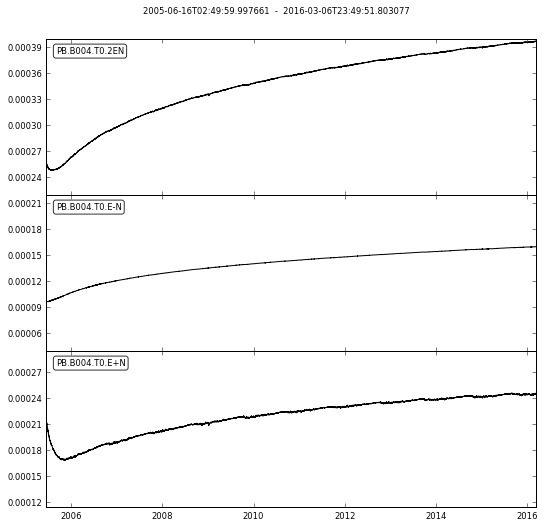

In [32]:
st.select(channel='*E*').plot(method='full')

In [24]:
# first estimate and remove a long-term trend and exponential strain,
# mostly to remove the long-term borehole curing

# to estimate a correction, create a dictionary with the input fit parameters
fpar = {'fitlinear':True,'fitconstant':True,'fitexp':True,
        'flm':np.array([0,float('inf')]),'expdec':300,
        'expdeclim':np.array([30,3000])}

# then compute the output fit parameters
X,Xb=Strain.fits.fits.fit(st,fpar=fpar)


In [26]:
# the output parameters are a dictionary of the parameters for each component
# so to see the parameters estimated for differential extension
print(X['E-N'])

{'expdec': masked_array(data = [ 911.33400403],
             mask = False,
       fill_value = 1e+20)
, 'constant': masked_array(data = [ 0.00014969],
             mask = False,
       fill_value = 1e+20)
, 'linear': masked_array(data = [  6.63586566e-09],
             mask = False,
       fill_value = 1e+20)
, 'exp': masked_array(data = [ -2.00637105e-05],
             mask = False,
       fill_value = 1e+20)
, 'exptref': UTCDateTime(2006, 9, 6, 23, 49, 58, 851439)}


In [27]:
# the input parameters are updated as well
print(fpar)

{'fitdaily': 0, 'fitexp': True, 'expdeclast': {'E+N': masked_array(data = [ 1005.55593802],
             mask = False,
       fill_value = 1e+20)
, 'E-N': masked_array(data = [ 907.02355166],
             mask = False,
       fill_value = 1e+20)
, '2EN': masked_array(data = [ 907.28205903],
             mask = False,
       fill_value = 1e+20)
}, 'expdeclim': {'E+N': array([[   30.,  3000.]]), 'E-N': array([[   30.,  3000.]]), '2EN': array([[   30.,  3000.]])}, 'fitdelresp': 0, 'tdel': [], 'fitatm': 0, 'fitconstant': True, 'chfit': array(['E+N', 'E-N', '2EN'], 
      dtype='|S3'), 'flm': array([  0.,  inf]), 'exptref': UTCDateTime(2006, 9, 6, 23, 49, 58, 851439), 'starttime': UTCDateTime(2006, 12, 15, 23, 49, 59, 997661), 'fittides': 0, 'expdec': {'E+N': masked_array(data = [ 1010.41934212],
             mask = False,
       fill_value = 1e+20)
, 'E-N': masked_array(data = [ 911.33400403],
             mask = False,
       fill_value = 1e+20)
, '2EN': masked_array(data = [ 911.61622429

In [33]:
# use the output fits to correct the data
stc,stp=Strain.fits.fits.correct(st,fpar,X)


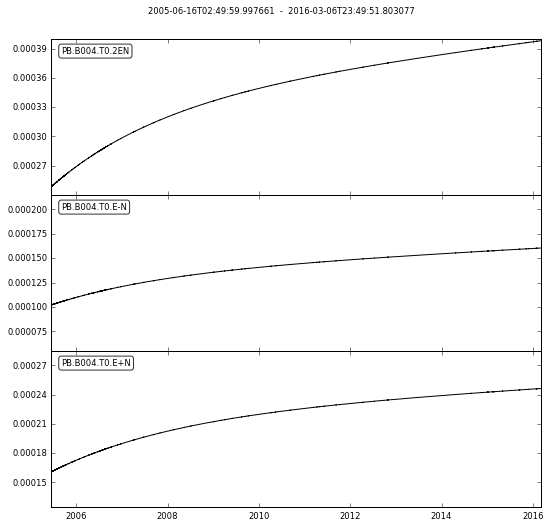

In [35]:
# this outputs the corrections used
stp.plot(method='full')

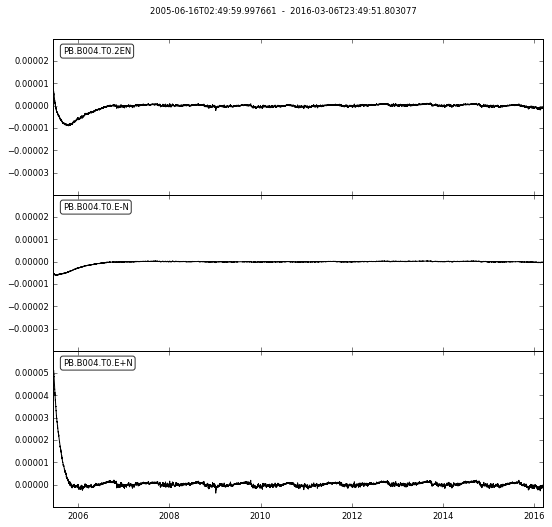

In [41]:
# it also outputs the corrected data,
# which should be flat since the trend has been removed
stc.select(channel='*E*').plot(method='full')

In [42]:
# note that large variation is left at early times because
# the start time for parameter estimation is after the data start time
print('Data start time: '+str(stc[0].stats.starttime))

print('Fit start time: '+str(fpar['starttime']))


Data start time: 2005-06-16T02:49:59.997661Z
Fit start time: 2006-12-15T23:49:59.997661Z


In [50]:
# now that we have a reasonably flat time series, 
# move on to more interesting corrections

# a new set of fit parameters, to remove tides and atmospheric pressure
fpar2 = {'fittides':True,'fitatm':True}

# specify tidal coefficients that are expected to be visible at roughly one 
# standard deviation level
fpar2['tidespec']='snr'
fpar2['tidepar']=1.

# compute the correction parameters in a limited frequency band (specified in Hz)
# note the actual corrections are computed at all frequencies---it's only
# the parameters that are estimated after filtering
fpar2['flm']=np.array([1./2.,6.])/86400.

print(fpar2)

{'fittides': True, 'fitatm': True, 'tidepar': 1.0, 'flm': array([  5.78703704e-06,   6.94444444e-05]), 'tidespec': 'snr'}


In [51]:
# compute the parameters---will take a while
X2,Xb2=Strain.fits.fits.fit(stc,fpar=fpar2)

In [52]:
# add these corrections
stc2,stp2=Strain.fits.fits.correct(stc,fpar=fpar2,X=X2)

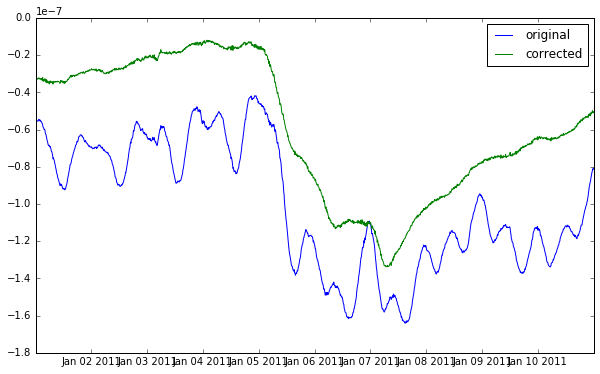

In [128]:
tst=obspy.UTCDateTime(2011,1,1)
tnd=tst+10*86400.
from matplotlib.dates import date2num
tstp,tndp=date2num(tst),date2num(tnd)

# compare some of the corrected data
tim,data=Strain.toplot.timdata(stc.select(channel='E-N')[0])
ii=np.logical_and(tim>=tstp,tim<=tndp)
plt.plot_date(tim[ii],data[ii],linestyle='-',marker=None,label='original',
                 color='b')

# compare some of the corrected data
tim,data=Strain.toplot.timdata(stc2.select(channel='E-N')[0])
ii=np.logical_and(tim>=tstp,tim<=tndp)
plt.plot_date(tim[ii],data[ii],linestyle='-',marker=None,label='corrected',
                 color='g')

plt.legend()


In [102]:
# from these corrections, we have amplitudes of the atmospheric response 
# on each component
print('barometric response coefficients in strain per Pa')
for ch in X2.keys():
    print(ch+': '+str(X2[ch]['atm'][0]))

barometric response coefficients in strain per Pa
E+N: -3.55411876081e-11
E-N: -4.04827929216e-12
2EN: -1.98076483265e-11


In [106]:
# identify the components of strain that have small atmospheric responses
cfn,cfnst,cfnsto = Strain.projcomp.nonatm(X2)

# cfn tells you the coefficients needed to make each of the new components
# so to make the non-atmospheric components closest to E-N, 
# you need the following combination of components
print(cfn['E-N-na'])


{'E+N': -0.086482692025303565, 'E-N': 0.9950867722605311, '2EN': -0.048198129135626135}


In [108]:
# create a new strain time series with these components
# start from the data corrected for the long-term trend,
# as that won't be crucial in the future
sta = Strain.projcomp.newch(stc,cfnst)+st.select(channel='RDO')

print(sta)

4 Trace(s) in Stream:
PB.B004.T0.E-N-na | 2005-06-16T02:49:59.997661Z - 2016-03-06T23:49:51.803077Z | 600.0 s, 564031 samples (masked)
PB.B004.T0.E+N-na | 2005-06-16T02:49:59.997661Z - 2016-03-06T23:49:51.803077Z | 600.0 s, 564031 samples (masked)
PB.B004.T0.2EN-na | 2005-06-16T02:49:59.997661Z - 2016-03-06T23:49:51.803077Z | 600.0 s, 564031 samples (masked)
PB.B004.TS.RDO    | 2005-06-16T02:49:59.997661Z - 2016-03-06T23:49:51.803077Z | 600.0 s, 564031 samples (masked)


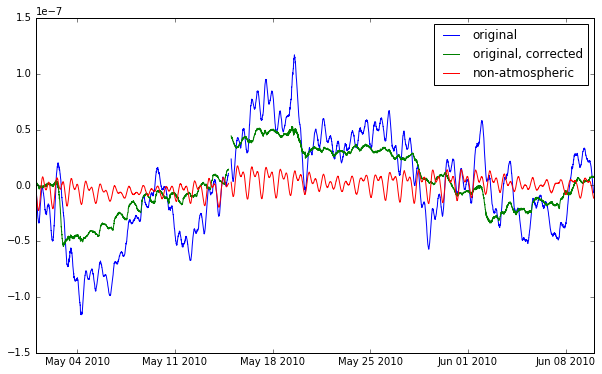

In [127]:
# compare these time series with the atmospheric components 
# both uncorrected for tides and pressure
# the tides are still there, but 
# much of the variation disappears when we use the non-atmospheric components

tst=obspy.UTCDateTime(2010,5,1)
tnd=tst+40*86400.
from matplotlib.dates import date2num
tstp,tndp=date2num(tst),date2num(tnd)

# original components
tim,data=Strain.toplot.timdata(stc.select(channel='E-N')[0])
ii=np.logical_and(tim>=tstp,tim<=tndp)
plt.plot_date(tim[ii],data[ii]-np.median(data[ii]),linestyle='-',marker=None,
                  label='original',color='b')

# original components, corrected
tim,data=Strain.toplot.timdata(stc2.select(channel='E-N')[0])
ii=np.logical_and(tim>=tstp,tim<=tndp)
plt.plot_date(tim[ii],data[ii]-np.median(data[ii]),linestyle='-',marker=None,
                  label='original, corrected',color='g')

# non-atmospheric components
tim,data=Strain.toplot.timdata(sta.select(channel='E-N-na')[0])
ii=np.logical_and(tim>=tstp,tim<=tndp)
plt.plot_date(tim[ii],data[ii]-np.median(data[ii]),linestyle='-',marker=None,
                  label='non-atmospheric',color='r')

plt.legend()

In [115]:
# correct the non-atmospheric components for tides but not pressure
# now that we have a reasonably flat time series, 
# move on to more interesting corrections

# a new set of fit parameters, to remove tides and atmospheric pressure
fpara = {'fittides':True,'fitatm':False}

# specify tidal coefficients that are expected to be visible at roughly one 
# standard deviation level
fpara['tidespec']='snr'
fpara['tidepar']=1.

# compute the correction parameters in a limited frequency band (specified in Hz)
# note the actual corrections are computed at all frequencies---it's only
# the parameters that are estimated after filtering
fpara['flm']=np.array([1./2.,6.])/86400.

print(fpara)


{'fittides': True, 'fitatm': False, 'tidepar': 1.0, 'flm': array([  5.78703704e-06,   6.94444444e-05]), 'tidespec': 'snr'}


In [116]:
# compute the parameters---will take a while
Xa,Xba=Strain.fits.fits.fit(sta,fpar=fpara)

In [117]:
# add these corrections
stac,stap=Strain.fits.fits.correct(sta,fpar=fpara,X=Xa)

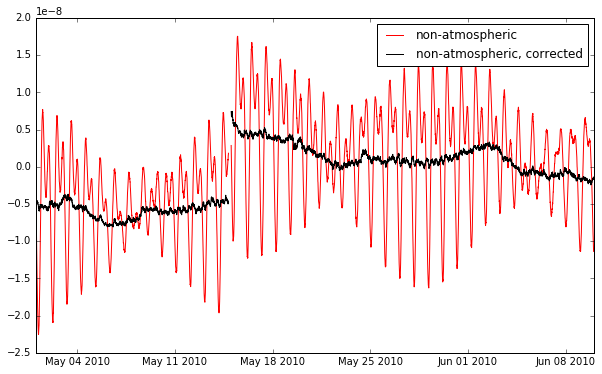

In [126]:
# compare these time series with the atmospheric components 
# both uncorrected for tides and pressure
# the tides are still there, but 
# much of the variation disappears when we use the non-atmospheric components

tst=obspy.UTCDateTime(2010,5,1)
tnd=tst+40*86400.
from matplotlib.dates import date2num
tstp,tndp=date2num(tst),date2num(tnd)

# non-atmospheric components
tim,data=Strain.toplot.timdata(sta.select(channel='E-N-na')[0])
ii=np.logical_and(tim>=tstp,tim<=tndp)
plt.plot_date(tim[ii],data[ii]-np.median(data[ii]),linestyle='-',marker=None,
                  label='non-atmospheric',color='r')

# non-atmospheric components, corrected
tim,data=Strain.toplot.timdata(stac.select(channel='E-N-na')[0])
ii=np.logical_and(tim>=tstp,tim<=tndp)
plt.plot_date(tim[ii],data[ii]-np.median(data[ii]),linestyle='-',marker=None,
              label='non-atmospheric, corrected',color='k')

plt.legend()